# Análise do desempenho do modelo de detecção de violência

[Voltar ao Índice](00_indice.ipynb)

Nosso objetivo é verificar se o modelo de IA utilizado neste projeto está estimando corretamente os níveis de violência e se essa estimativa é adequada para diversos grupos sociais e tipos de violência.
Para tanto, vamos utilizar novas anotações de tweets feitas por parceiros.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from glob import glob
from functools import partial
from multiprocessing import Pool
from importlib import reload

import src.tweet_analysis as com
import src.analysis_functions as af
import xavy.dataframes as xd
import xavy.drive as dr
import xavy.stats as xs
import xavy.plots as xp
import xavy.mltools as ml

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


**ATENÇÃO:** É preciso eliminar a contagem dupla caso dois anotadores sejam a mesma pessoa.

## Carregando classificações feitas pela máquina

In [2]:
# Lista arquivos a serem anotados por cada grupo, ainda vazios:
sample_files = glob('../dados/processados/amostra_tweets_para_anotacao_*.csv')
# Carrega IDs do tweets de cada grupo:
sampled_tweets_df = pd.concat([af.load_group_data(f) for f in sample_files], ignore_index=True)
# Contabiliza grupos que foram alocados a cada tweet:
sampled_tweets_df['n'] = 1
sampled_tweets_df = sampled_tweets_df.pivot_table(index='id', columns='grupo', values='n', aggfunc='sum').fillna(0).astype(int)
sampled_tweets_df['n_grupos'] = sampled_tweets_df.sum(axis=1)

In [3]:
# Carrega os tweets:
reload_tweets = False
tweet_selection_file = '../dados/processados/amostra_tweets_escolhidos_para_anotacao.csv'

if reload_tweets is True:
    # Carrega as configurações:
    config = com.read_config()

    # Load tweets:
    tweets_df = com.etl_tweets_df(config['scored_tweets_dir'], config['target_model'], config['bad_users'])
    # Filter tweets directed to a single person:
    direct_df = com.select_direct_text_tweets(tweets_df)

    # Select tweets that were chosen for annotation:
    tweet_cols = ['id', 'created_at', 'text', 'tweet_url', 'direct_reply', 'batch_user', 'hate_score', 'target_prob']
    tweets4annotation_df = direct_df.loc[direct_df['id'].isin(sampled_tweets_df.index), tweet_cols]
    
    # Salva os tweets selecionados, para evitar ter que carregar tudo de novo:
    #tweets4annotation_df.to_csv(tweet_selection_file, index=False)

else:
    # Carrega tweets já selecionados:
    tweets4annotation_df = pd.read_csv(tweet_selection_file)

assert xd.iskeyQ(tweets4annotation_df[['id']])

## Carregando e preparando as anotações feitas

Para podermos carregar uma planilha do google sheets diretamente, precisamos que ela dê acesso ao seguinte usuário:
 `violentometro-sheets@ceweb-xavier.iam.gserviceaccount.com`

In [4]:
# Atualiza a lista de sheets com anotações a partir do Google Sheets:
dir_df = dr.load_data_from_local_or_drive('https://docs.google.com/spreadsheets/d/1C_eDa4JUcSuKXNJ8c5cI_3aOSMiDlX-hRsVz71WUZz4', 
                                          '../dados/brutos/aux/tabela_planilhas_tweets_anotados.csv', force_drive=False)
print(xd.bold('Repetição de anotadores'))
xd.check_guarda_compartilhada(dir_df, 'Responsável', 'Anotador')

Loading data from local file...
Repetição de anotadores


Responsável
Xavier    [A06, A09, A10, A13]
Name: Anotador, dtype: object

In [5]:
ignore_annotators = ['A13']

# Junta as anotações aos tweets:
tweets_annotated_df = tweets4annotation_df
for grupo in dir_df['Grupo'].drop_duplicates():
    print('* Grupo: {}'.format(grupo))
    # Carrega dados de cada anotador dentro de um grupo social:
    df = af.etl_group_annotations(dir_df, grupo, force_drive=False)
    tweets_annotated_df = tweets_annotated_df.join(df, how='outer', on='id')

n_unmatched = tweets_annotated_df['created_at'].isnull().sum()
assert n_unmatched == 0, 'Tivemos {} anotacoes que não foram associadas a nenhum tweet.'.format(n_unmatched)

# Calcula a categoria final depois de usar majority voting 
af.summarize_annotations(tweets_annotated_df, ignore_annotators=ignore_annotators, defaults=[0, 0, 0, 0, 0])

# Verifica se dados estão OK:
print('')
af.security_checks(tweets_annotated_df)

tweets_annotated_df = tweets_annotated_df.join(sampled_tweets_df, on='id')

* Grupo: Pessoas negras
Loading data from local file...
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Mulheres
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: LGBTs
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Controle
Loading data from local file...
Loading data from local file...
Loading data from local file...

!! Os seguintes tweets não possuem o mesmo número de anotações em todas as categorias: {674, 579, 644, 743, 1019, 1191, 237, 1198, 559, 787, 693, 86, 917, 88, 1430, 731, 412, 574}


In [6]:
for col in af.find_cols(tweets_annotated_df, 'cand_objeto_A'):
    print(col, tweets_annotated_df[col].unique())

cand_objeto_A01 [nan  1.  0.]
cand_objeto_A02 [nan  1.  0.]
cand_objeto_A03 [nan  1.  0.]
cand_objeto_A13 [nan  1.  0.]
cand_objeto_A04 [ 1. nan  0.]
cand_objeto_A05 [ 0. nan  1.]
cand_objeto_A06 [ 1. nan  0.]
cand_objeto_A07 [nan  1.  0.]
cand_objeto_A08 [nan  1.  0.]
cand_objeto_A09 [nan  1.  0.]
cand_objeto_A10 [nan  1.  0.]
cand_objeto_A11 [nan]
cand_objeto_A12 [nan]


### Estatísticas das anotações

In [7]:
# Contabiliza as anotações para acompanhar o trabalho dos anotadores:
af.count_annotations_made(tweets_annotated_df)

label,cand_objeto,lgbtfobico,machista,racista,violento
anotador,,,,,
A01,393,389,393,393,393
A02,394,394,394,394,395
A03,400,400,400,399,400
A04,400,399,400,400,400
A05,400,400,400,400,400
A06,400,400,400,400,400
A07,396,398,398,398,398
A08,397,397,396,395,398
A09,400,400,400,400,400


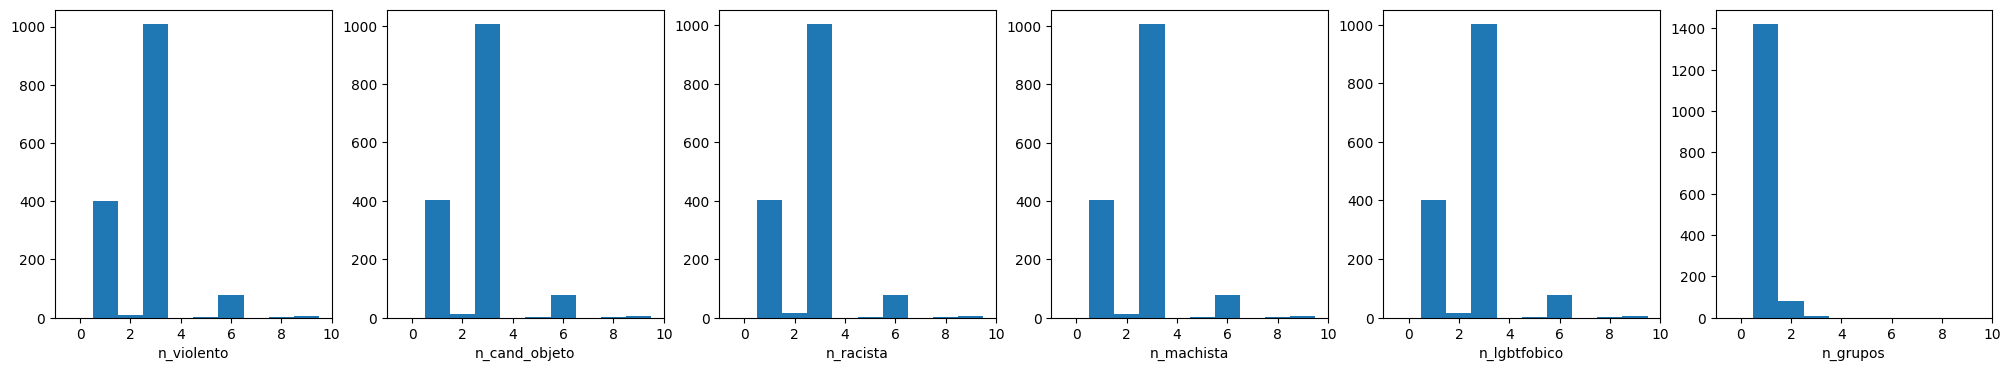

In [8]:
# Número de tweets com cada número de anotações feitas:
count_cols = af.find_cols(tweets_annotated_df, 'n_')
pl.figure(figsize=(25,4))
for i, col in enumerate(count_cols):
    pl.subplot(1, len(count_cols), i + 1)
    pl.hist(tweets_annotated_df[col], bins=np.arange(-0.5, 10.5, 1))
    pl.xlabel(col)
pl.show()

In [9]:
xd.print_string_series(tweets_annotated_df.query('cand_objeto_final == 0 and violento_final == 0').sample(3, random_state=3)['tweet_url'])

51: https://www.twitter.com/well11sp/status/1560283460576624641
664: https://www.twitter.com/MarliCella/status/1566483908652408834
1224: https://www.twitter.com/Kelly78637956/status/1574168831001436160


In [10]:
tweets_annotated_df['n_violento'].value_counts().sort_index()

1     402
2      10
3    1008
5       1
6      77
8       1
9       7
Name: n_violento, dtype: int64

## Concordância entre anotadores

### Fleiss' Kappa

In [11]:
def compute_kappa(df):
    kappa = xs.fleiss_kappa(df.astype(int).values, N_classes=2, n_votes_per_class=False)
    return kappa

def get_random_kappa(seed, df):
    return compute_kappa(xs.break_column_correlations(df, seed))

def plot_agreement_report(dir_df, tweets_df, grupo, campo, min_tweets=100, n_kappa_samples=4000, seed0=35):
    
    # Seleciona anotações:
    anotadores = dir_df.query('Grupo == "{}"'.format(grupo))['Anotador']
    cols = campo + '_' + anotadores
    n_tweets = (~tweets_df[cols].isnull()).sum()
    good_anotators = n_tweets.loc[n_tweets > min_tweets]
    X = tweets_df.loc[~tweets_df[good_anotators.index].isnull().any(axis=1), good_anotators.index]

    # Calcula concordância entre eles:
    kappa = compute_kappa(X)

    # Create a sample of kappas for randomly tagged tweets:
    with Pool() as pool:
        seeds = list(range(seed0, seed0 + n_kappa_samples))
        rand_kappas = pool.map(partial(get_random_kappa, df=X), seeds) 
    #rand_kappas = np.array([get_random_kappa(i + seed0, X) for i in range(n_kappa_samples)])

    # Cria histograma :
    pl.hist(rand_kappas)
    ax = pl.gca()
    anot_counts = good_anotators.rename(dict(zip(cols, anotadores)))
    pl.text(0.95, 0.95, '# anotações:\n{}\n\nK: {:.3f}'.format(anot_counts, kappa), transform=ax.transAxes, va='top', ha='right')
    pl.xlabel('Kappa aleatório')
    pl.ylabel('# amostras')
    pl.title(campo + ' - ' + grupo)

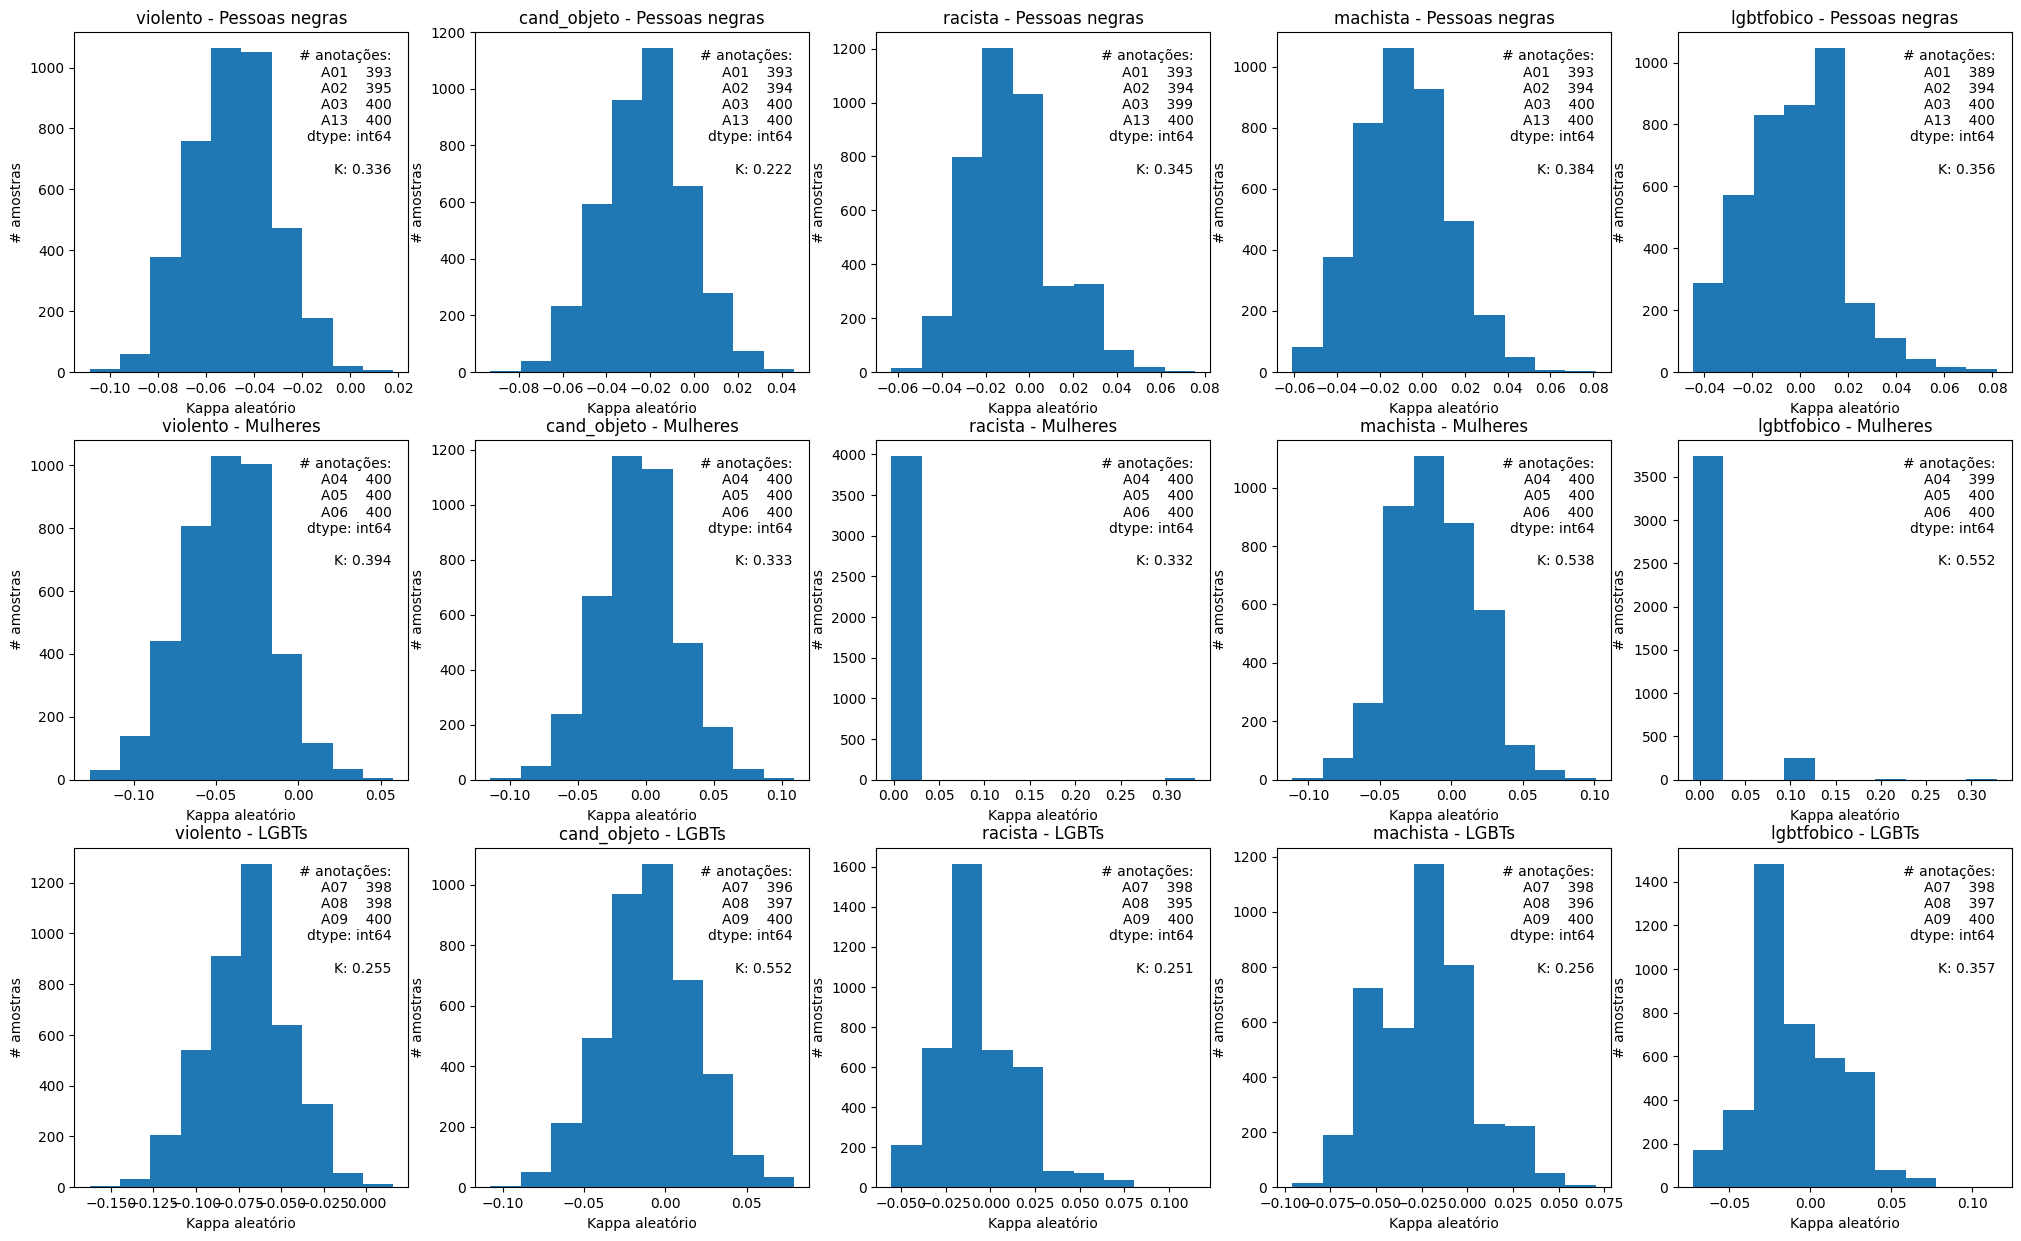

In [12]:
grupos = ['Pessoas negras', 'Mulheres', 'LGBTs']
campos = ['violento', 'cand_objeto', 'racista', 'machista', 'lgbtfobico']

n_campos = len(campos)
n_grupos = len(grupos)
pl.figure(figsize=(5 * n_campos, 5 * n_grupos))
for i, grupo in enumerate(grupos):
    for j, campo in enumerate(campos):
        pl.subplot(n_grupos, n_campos, 1 + j + i * n_campos)
        plot_agreement_report(dir_df, tweets_annotated_df, grupo, campo)


### Relação com anotador controle

In [15]:
from sklearn.metrics import confusion_matrix

In [8]:
def show_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    
    cols = [campo + '_' + a1, campo + '_' + a2]
    data_df = tweets_df.loc[~tweets_df[cols].isnull().any(axis=1), cols]
    X = confusion_matrix(data_df[cols[0]], data_df[cols[1]], normalize=normalize)
    if len(X) == 0:
        X = np.array([[np.NaN, np.NaN], [np.NaN, np.NaN]])
    cm_df = pd.DataFrame(data=X, index=[a1 + ': Não', a1 + ': Sim'], columns=[a2 + ': Não', a2 + ': Sim'])
    cm_df.style.set_caption(campo)
    return cm_df

def std_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    return show_confusion_matrix(tweets_df, campo, a1, a2, normalize=normalize).set_index(np.array(['Controle: Não', 'Controle: Sim']))

In [9]:
controle = dir_df.query('Responsável == "Xavier"').set_index('Grupo')['Anotador']
controle.name = 'Controle'
anotadores_pairs_df = dir_df.query('Responsável != "Xavier"').set_index('Grupo')[['Anotador']].join(controle)

In [18]:
campo = 'violento'
sigma_list = []
for campo in campos:
    print(xd.bold(campo))
    cm_dfs = []
    for grupo in grupos:
        sel_pair_df = anotadores_pairs_df.query('Grupo == "{}"'.format(grupo))
        for a1, a2 in zip(sel_pair_df['Controle'], sel_pair_df['Anotador']):
            cm = std_confusion_matrix(tweets_annotated_df, campo, a1, a2, normalize=None)
            cm_dfs.append(cm)
            
            anotador = cm.columns[0].split(':')[0]
            n_sigma  = (cm.iloc[0,1] - cm.iloc[1,0]) / np.sqrt(cm.iloc[0,1] + cm.iloc[1,0])
            sigma_list.append({'campo': campo, 'anotador': anotador, 'n_sigma':n_sigma})

    confusion_df = pd.concat(cm_dfs, axis=1)
    display(confusion_df)

violento


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,100,160,229,33,139,126,247,37,165,119,184,153,295,42
Controle: Sim,4,129,55,78,10,125,47,69,3,113,2,59,26,35


cand_objeto


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,26,114,109,30,97,47,172,15,107,80,148,35,173,11
Controle: Sim,35,218,60,195,97,159,63,150,89,124,44,169,73,140


racista


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,365,20,373,13,354,37,398,1,399,0,360,32,371,18
Controle: Sim,3,5,6,2,1,7,0,1,1,0,2,4,4,2


machista


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,340,33,360,14,328,52,335,19,295,59,329,62,356,33
Controle: Sim,7,13,6,14,3,17,12,34,7,39,1,6,2,5


lgbtfobico


,A01: Não,A01: Sim,A02: Não,A02: Sim,A03: Não,A03: Sim,A04: Não,A04: Sim,A05: Não,A05: Sim,A07: Não,A07: Sim,A08: Não,A08: Sim
Controle: Não,361,19,377,8,377,13,394,1,394,1,353,36,369,19
Controle: Sim,2,7,3,6,6,4,3,1,3,2,0,9,2,7


In [19]:
sigma_df = pd.DataFrame(sigma_list)
sigma_df['abs_n_sigma'] = np.abs(sigma_df['n_sigma'])
sigma_df = sigma_df.sort_values('abs_n_sigma', ascending=False)
sigma_df.query('abs_n_sigma >= 0 and campo == "violento"')

,campo,anotador,n_sigma,abs_n_sigma
0,violento,A01,12.181553,12.181553
5,violento,A07,12.128612,12.128612
4,violento,A05,10.502147,10.502147
2,violento,A03,9.946918,9.946918
1,violento,A02,-2.345208,2.345208
6,violento,A08,1.940285,1.940285
3,violento,A04,-1.091089,1.091089


In [28]:
campo = 'racista'
anotador = 'A01'
row = anotadores_pairs_df.query('Anotador == "{}"'.format(anotador)).iloc[0]
print(row)
query0 = '({0}_{1} == 1 and {0}_{2} == 0)'
query1 = '({0}_{1} == 0 and {0}_{2} == 1)'
sel0 = tweets_annotated_df.query(query0.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Anotador não marcou ({})'.format(len(sel0))))
xd.print_string_series(sel0.sample(min(10, len(sel0))))
sel1 = tweets_annotated_df.query(query1.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Controle não marcou ({})'.format(len(sel1))))
xd.print_string_series(sel1.sample(min(10, len(sel1))))

Anotador    A01
Controle    A13
Name: Pessoas negras, dtype: object
Anotador não marcou (3)
https://www.twitter.com/Bruno__Rogers/status/1573345741719879680: @danimontpsol O povo estava com toda razão. Lixo deve ser jogado fora mesmo. Sem pena. 

O RJ é 100% bolsonarista mermão. Quem não aceita isso é esquerdista fracassado.
https://www.twitter.com/xarope_bolado/status/1567979648956481538: @beatrizcaminha Por isso que me dá uma raiva tremenda quando alguém vem com esse papo de "ah,extermínio da população negra",mimimi...me poupe!!!!Eu sou NEGÃO,p...,não coitadinho,nem vitiminha,nem escravinho!!!!Ah,e GOD SAVE THE QUEEN!!!!REST IN PEACE!!!!!!!!!!
https://www.twitter.com/Jed_KapIan/status/1574472401269788680: @renatasouzario Kkkkk vai lá defensora dos traficantes fracos e oprimidos
Controle não marcou (20)
https://www.twitter.com/Hellephant2/status/1568215733213036545: @southaferreira Mimimi racismo imperialismo, enquanto isso faz parte de um partido comunista, ideologia responsável por 

## Análise

### Desempenho individual

In [8]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

In [10]:
# Comparação com o treinamento:
test_df = tweets_annotated_df.query('controle == 0')
frac_violento = 0.164
# Metrics:
for name, scorer in {'acc': accuracy_score, 'f1': f1_score, 'prec': precision_score, 'rec': recall_score, 'ghr': ml.geomean_hit_rate}.items():
    s = np.mean(af.fixed_proportion_scores(test_df, 'violento_final', 'hate_score', frac_violento, scorer, 0.5))
    print('{}: {:.3f}'.format(name, s))

acc: 0.736
f1: 0.445
prec: 0.341
rec: 0.646
ghr: 0.700


In [11]:
# Fração dos tweets que foram anotados como violentos:
test_df['violento_final'].mean()

0.4023508137432188

In [12]:
# Estimativa de performance no contexto das eleições:
test_df = tweets_annotated_df.query('controle == 0')
frac_violento = 0.11
# Metrics:
for name, scorer in {'acc': accuracy_score, 'f1': f1_score, 'prec': precision_score, 'rec': recall_score, 'ghr': ml.geomean_hit_rate}.items():
    s = np.mean(af.fixed_proportion_scores(test_df, 'violento_final', 'hate_score', frac_violento, scorer, 0.5))
    print('{}: {:.3f}'.format(name, s))

acc: 0.742
f1: 0.357
prec: 0.246
rec: 0.656
ghr: 0.700


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


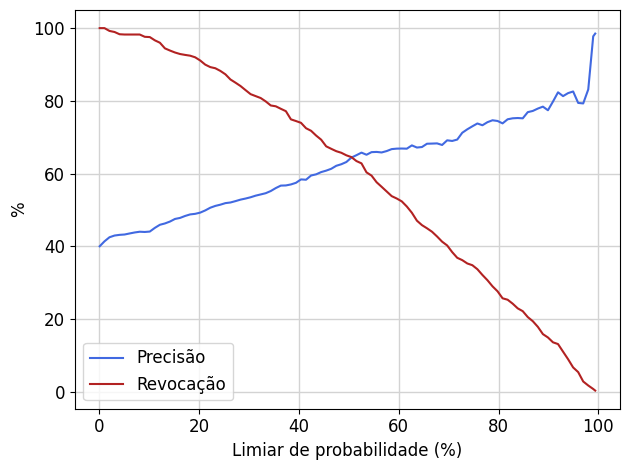

In [126]:
precision, recall, threshold = [], [], []
x = np.linspace(0, 1, 100)
for n in range(200):
    sample_df = af.sample_fixed_proportion(test_df, 'violento_final', 0.40)
    p, r, t = precision_recall_curve(sample_df['violento_final'], sample_df['hate_score'])
    precision.append(np.interp(x, t, p[:-1]))
    recall.append(np.interp(x, t, r[:-1]))
    threshold.append(np.interp(x, t, t))

threshold = np.array(threshold).mean(axis=0)
precision = np.array(precision).mean(axis=0)
recall    = np.array(recall).mean(axis=0)

pl.plot(threshold * 100, precision * 100, label='Precisão', color='royalblue')
pl.plot(threshold * 100, recall * 100, label='Revocação', color='firebrick')
pl.xlabel('Limiar de probabilidade (%)', fontsize=12)
pl.ylabel('%', fontsize=12)
pl.tick_params(labelsize=12)
pl.legend(fontsize=12)
pl.grid(linewidth=1, color='lightgray')
pl.tight_layout()
pl.savefig('../resultados/plots/precision-recall-curve_aplicacao-11pc.eps')
pl.savefig('../resultados/plots/precision-recall-curve_aplicacao-11pc.png')
pl.show()

### Desempenho geral

In [16]:
test_df['hate_score'].mean()

0.4373715236757052

In [15]:
test_df['violento_final'].mean()

0.4023508137432188

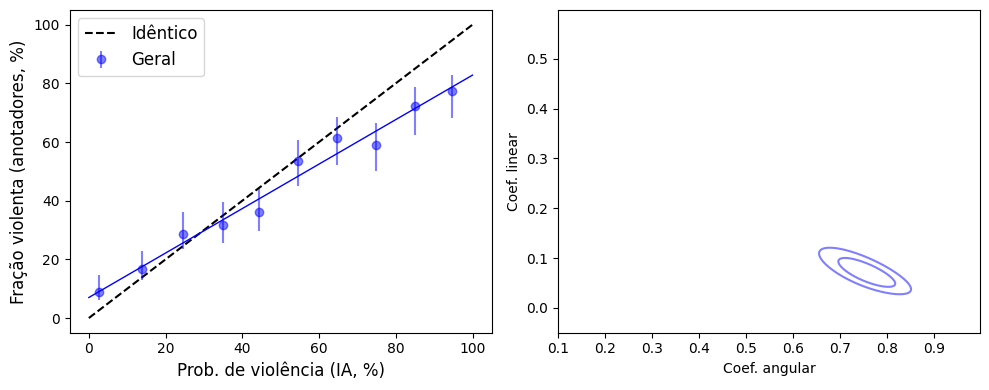

In [13]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Idêntico')

af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0'), 'Geral', 'b')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

### Desempenho vs. objeto do comentário

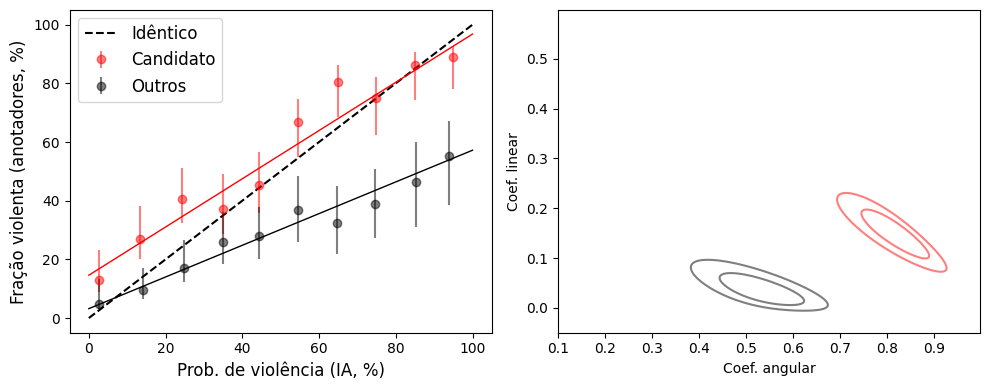

In [38]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Idêntico')

af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 1 and controle == 0'), 'Candidato', 'r')
af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 0 and controle == 0'), 'Outros', 'k')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

### Diferentes grupos com um mesmo anotador

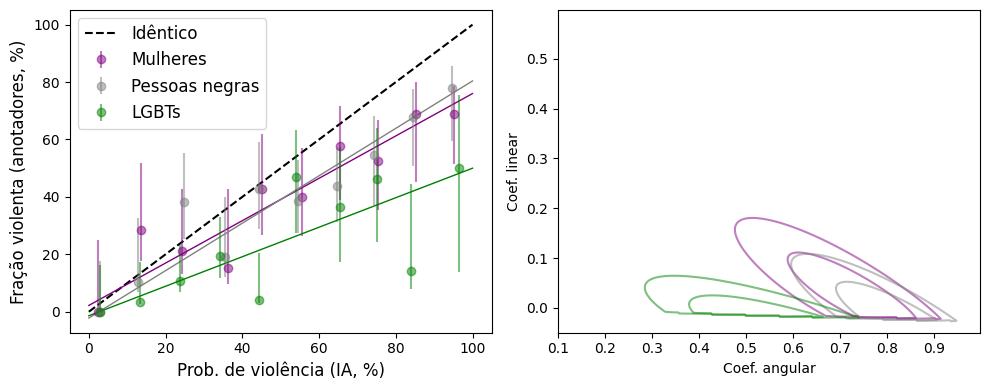

In [39]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Idêntico')

a = 'A06'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Mulheres', 'purple', final_suffix='_' + a)
a = 'A13'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Pessoas negras', 'gray', final_suffix='_' + a)
a = 'A09'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'LGBTs', 'green', final_suffix='_' + a)

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

### Cada grupo com 3 anotadores

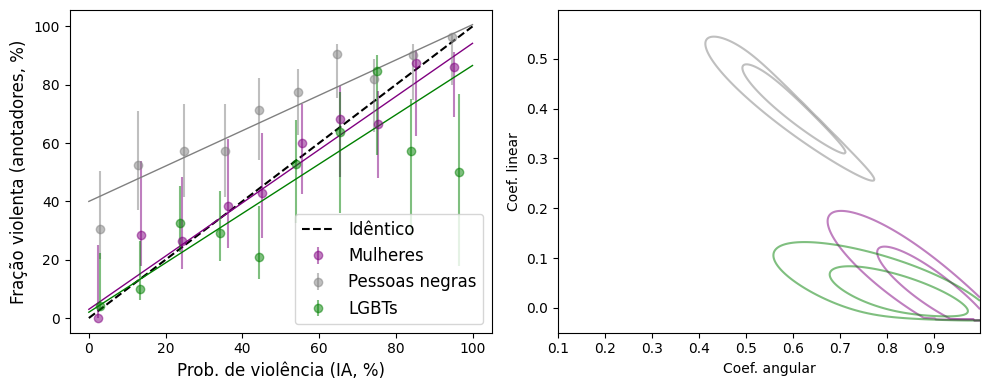

In [40]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Idêntico')

af.plot_tweets_correspondence(tweets_annotated_df.query('mulheres == 1 and cand_objeto_final == 1'), 'Mulheres', 'purple')
af.plot_tweets_correspondence(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1'), 'Pessoas negras', 'gray')
af.plot_tweets_correspondence(tweets_annotated_df.query('lgbts == 1 and cand_objeto_final == 1'), 'LGBTs', 'green')

pl.subplot(1,2,1)
pl.xlabel('Prob. de violência (IA, %)', fontsize=12)
pl.ylabel('Fração violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

In [23]:
# Tweets direcionado a candidaturas negras anotados como violentos e rankeados como não violentos pela IA:
xd.print_string_series(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1 and violento_final == 1 and hate_score < 0.2').set_index('tweet_url')['text'])

https://www.twitter.com/CillerTavares/status/1561346219045261315: @guimaraes13PT @ricardostuckert O Homem chamado capitão cueca  volta a atacar.
https://www.twitter.com/Carlinhosclube/status/1564253251998031873: @jfernandaBrasil Tá loka?
https://www.twitter.com/lukinha360games/status/1564440907755167744: @LeoSuricate Aí mente DEMAIS 😏
https://www.twitter.com/JosAlfredoDeTo1/status/1564625070550663168: @andremarianors KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
https://www.twitter.com/MarcioBraga01/status/1564802248118501378: @tiriricanaweb Volta p circo de onde veio.. o da política já tem palhaços demais!
https://www.twitter.com/Dansouza81/status/1564917677059080200: @Eunicio Falou o picareta da empresa Manchester que ganhou um contrato de 1 bilhão da Petrobrás sem Licitação!!!!
https://www.twitter.com/rodrigokrfarias/status/1567679929168306178: @fabiofelixdf O Brasil teve um superávit nas contas públicas de R$19,3bi. Maior índice em 11 anos. E outra, inflação boa é a de 71% e 62% da Arge

### Por tipo de violência

In [8]:
from scipy.stats import ks_2samp

In [30]:
def compare_scores_per_violence_type(tweets_df, campo, color=None):

    edges = np.arange(0, 101, 10)
    generic  = tweets_df.query(campo + '_final == 0 and violento_final == 1')['hate_score'] * 100
    specific = tweets_df.query(campo + '_final == 1 and violento_final == 1')['hate_score'] * 100
    ks = ks_2samp(generic, specific)

    ax = pl.gca()
    pl.text(0.02, 0.8, 'KS p-value: {:.3f}'.format(ks.pvalue), transform=ax.transAxes, ha='left', va='top', fontsize=12)
    xp.errorbar_hist(specific, bins=edges, alpha=0.4, color=color, density=True, label=campo.replace('_', ' ').capitalize())
    xp.errorbar_hist(generic, bins=edges, alpha=0.4, color='gray', density=True, label='Outros')

    pl.xlabel('Prob. de violência (IA, %)')
    pl.legend(loc='upper left', fontsize=12)
    #pl.title('Nota da IA para comentários violentos, por tipo')

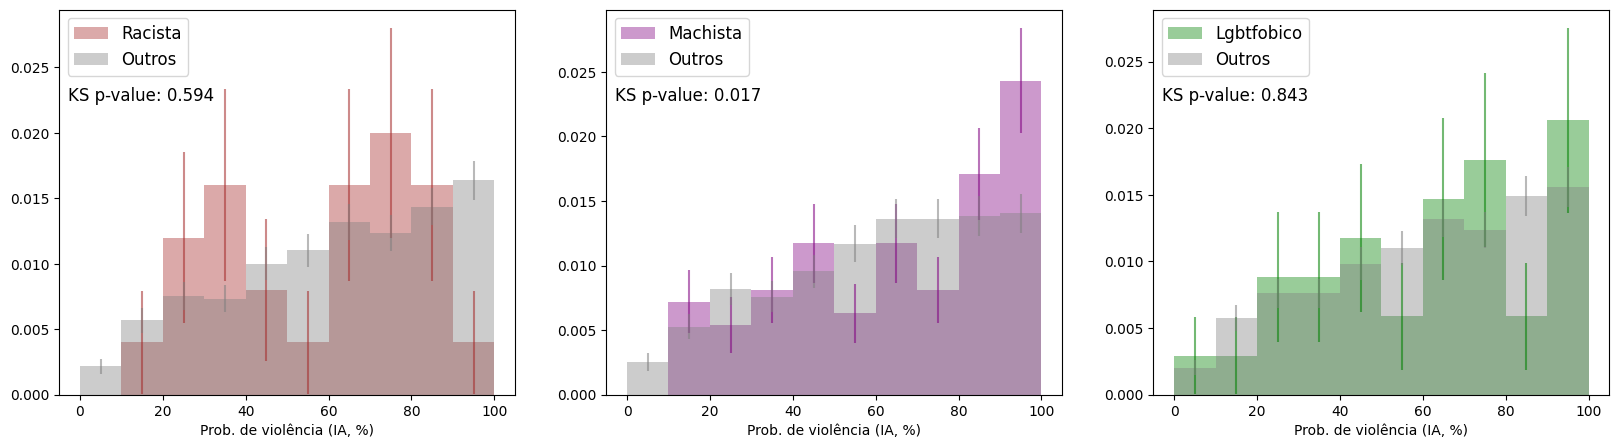

In [31]:
pl.figure(figsize=(20, 5))
for i, campo, cor in zip([1, 2, 3], ['racista', 'machista', 'lgbtfobico'], ['brown', 'purple', 'g']):
    pl.subplot(1, 3, i)
    compare_scores_per_violence_type(tweets_annotated_df, campo, cor)

# Lixo

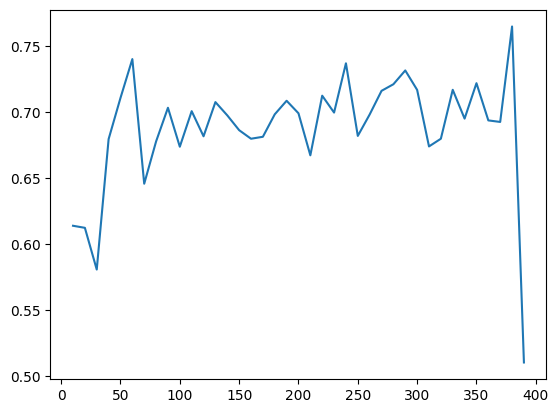

In [73]:
# Demonstrando independência da métrica com a proporção entre as categorias:
tot = 400
n = 10
x = range(10, 400, 10)
sc = []
for n in x:
    z = pd.concat([test_df.query('violento_final == 0').sample(tot - n), test_df.query('violento_final == 1').sample(n)])
    sc.append(ml.geomean_hit_rate(z['violento_final'], z['hate_score'] > 0.5))

pl.plot(x, sc)
pl.show()